**前言**：节内容是 [Datawhale六月组队学习 - 图神经网络- Task3 基于图神经网络的节点表征学习](https://github.com/datawhalechina/team-learning-nlp/blob/master/GNN/Markdown%E7%89%88%E6%9C%AC/5-%E5%9F%BA%E4%BA%8E%E5%9B%BE%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E7%9A%84%E8%8A%82%E7%82%B9%E8%A1%A8%E5%BE%81%E5%AD%A6%E4%B9%A0.md) 的学习笔记，学习周期4天

### 基础准备

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

载入数据集

In [69]:
dataset = Planetoid(root='dataset/Cora', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


定义可视化函数

In [49]:
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy()) # 将高维的节点表征映射到二维平面空间
    plt.figure(figsize=(6,6))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

训练和测试用到的函数

In [70]:
def result(train, test, epoch=1001):
    train_loss = []
    train_acc = [];test_acc=[]
    for i in range(1, epoch):
        loss, acc = train()
        train_loss.append(loss)
        train_acc.append(acc)
        if i % 10 == 0:
            print('[Epoch {}/{}] Loss {:.4f}, train acc {:.4f}'.format(i, epoch-1, loss, acc))
            acc = test()
            test_acc.append(acc)
            print('Accuracy: {:.4f}'.format(acc))
        
    return (train_loss, train_acc, test_acc)

### MLP

In [10]:
import torch
from torch.nn import Linear
import torch.nn.functional as F

构造网络

In [71]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(42)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

MLP(
  (lin1): Linear(in_features=1433, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=7, bias=True)
)


模型训练

In [83]:
model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def MLP_train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc

def MLP_test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

%time (train_loss, train_acc, test_acc) = result(MLP_train, MLP_test)

[Epoch 10/1000] Loss 1.8882, train acc 0.3929
Accuracy: 0.1640
[Epoch 20/1000] Loss 1.7311, train acc 0.7357
Accuracy: 0.4870
[Epoch 30/1000] Loss 1.5055, train acc 0.7571
Accuracy: 0.4230
[Epoch 40/1000] Loss 1.2608, train acc 0.7571
Accuracy: 0.5000
[Epoch 50/1000] Loss 1.0268, train acc 0.8286
Accuracy: 0.5270
[Epoch 60/1000] Loss 0.8497, train acc 0.8357
Accuracy: 0.5390
[Epoch 70/1000] Loss 0.7122, train acc 0.8714
Accuracy: 0.5410
[Epoch 80/1000] Loss 0.6470, train acc 0.8357
Accuracy: 0.5430
[Epoch 90/1000] Loss 0.5856, train acc 0.8643
Accuracy: 0.5440
[Epoch 100/1000] Loss 0.6133, train acc 0.8429
Accuracy: 0.5440
[Epoch 110/1000] Loss 0.6120, train acc 0.8071
Accuracy: 0.5400
[Epoch 120/1000] Loss 0.4783, train acc 0.9286
Accuracy: 0.5350
[Epoch 130/1000] Loss 0.5159, train acc 0.8571
Accuracy: 0.5380
[Epoch 140/1000] Loss 0.4467, train acc 0.9286
Accuracy: 0.5290
[Epoch 150/1000] Loss 0.4937, train acc 0.8786
Accuracy: 0.5440
[Epoch 160/1000] Loss 0.4657, train acc 0.9143
Ac

简单可视化

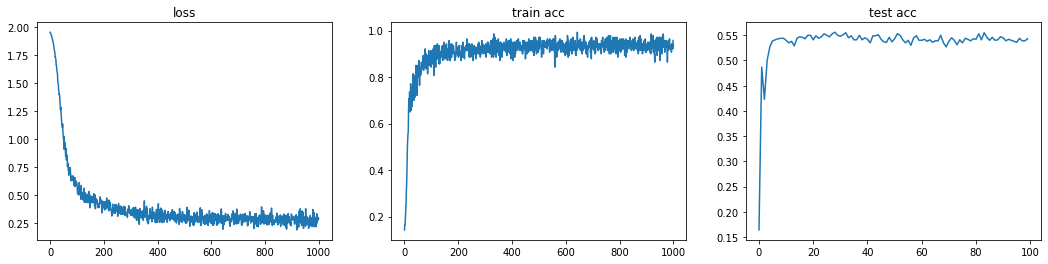

In [52]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

### GCN

In [16]:
from torch_geometric.nn import GCNConv

网络结构

In [74]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


未训练GCN节点表征可视化

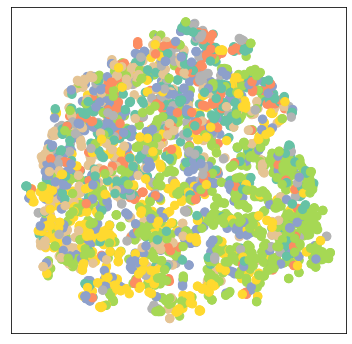

Wall time: 13.7 s


In [84]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
%time visualize(out, color=data.y)

模型训练

In [87]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

%time (train_loss, train_acc, test_acc) = result(train, test)

[Epoch 10/1000] Loss 1.8725, train acc 0.6429
Accuracy: 0.5710
[Epoch 20/1000] Loss 1.7589, train acc 0.7357
Accuracy: 0.6920
[Epoch 30/1000] Loss 1.5724, train acc 0.8286
Accuracy: 0.7300
[Epoch 40/1000] Loss 1.3877, train acc 0.8571
Accuracy: 0.7710
[Epoch 50/1000] Loss 1.1775, train acc 0.8786
Accuracy: 0.7800
[Epoch 60/1000] Loss 1.0346, train acc 0.8786
Accuracy: 0.7960
[Epoch 70/1000] Loss 0.8070, train acc 0.9071
Accuracy: 0.7990
[Epoch 80/1000] Loss 0.7042, train acc 0.9571
Accuracy: 0.8040
[Epoch 90/1000] Loss 0.6023, train acc 0.9500
Accuracy: 0.8020
[Epoch 100/1000] Loss 0.5700, train acc 0.9714
Accuracy: 0.8050
[Epoch 110/1000] Loss 0.5204, train acc 0.9714
Accuracy: 0.8050
[Epoch 120/1000] Loss 0.4676, train acc 0.9571
Accuracy: 0.8070
[Epoch 130/1000] Loss 0.4463, train acc 0.9571
Accuracy: 0.8150
[Epoch 140/1000] Loss 0.4118, train acc 0.9571
Accuracy: 0.8110
[Epoch 150/1000] Loss 0.4151, train acc 0.9571
Accuracy: 0.8050
[Epoch 160/1000] Loss 0.3753, train acc 0.9857
Ac

简单可视化

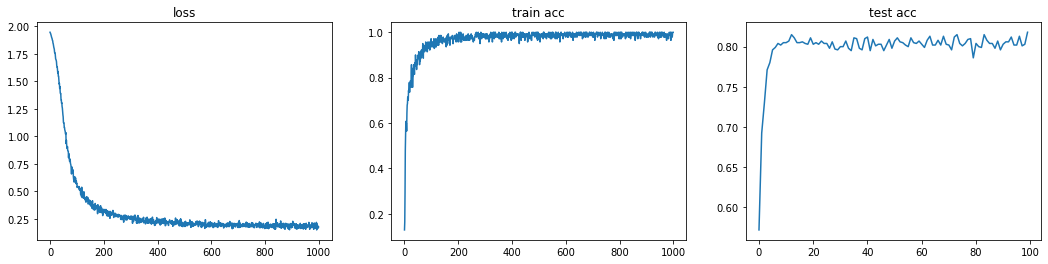

In [98]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

训练后GCN节点表征可视化

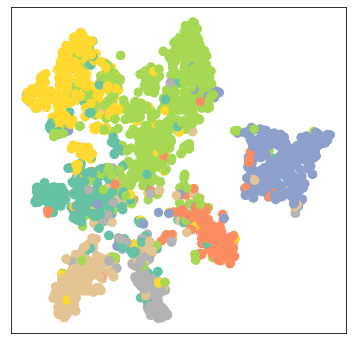

Wall time: 13.1 s


In [99]:
model.eval()

out = model(data.x, data.edge_index)
%time visualize(out, color=data.y)

### GAT

In [30]:
from torch_geometric.nn import GATConv

网络结构

In [31]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16)
print(model)

GAT(
  (conv1): GATConv(3703, 16, heads=1)
  (conv2): GATConv(16, 6, heads=1)
)


模型训练

In [89]:
model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

%time (train_loss, train_acc, test_acc) = result(train, test)

[Epoch 10/1000] Loss 1.8522, train acc 0.7929
Accuracy: 0.6900
[Epoch 20/1000] Loss 1.6747, train acc 0.8357
Accuracy: 0.7300
[Epoch 30/1000] Loss 1.4365, train acc 0.8286
Accuracy: 0.7430
[Epoch 40/1000] Loss 1.1556, train acc 0.8000
Accuracy: 0.7770
[Epoch 50/1000] Loss 0.8814, train acc 0.8571
Accuracy: 0.7710
[Epoch 60/1000] Loss 0.7253, train acc 0.8500
Accuracy: 0.7590
[Epoch 70/1000] Loss 0.5616, train acc 0.9143
Accuracy: 0.7160
[Epoch 80/1000] Loss 0.4660, train acc 0.9357
Accuracy: 0.7340
[Epoch 90/1000] Loss 0.3964, train acc 0.9500
Accuracy: 0.7270
[Epoch 100/1000] Loss 0.3746, train acc 0.9357
Accuracy: 0.7320
[Epoch 110/1000] Loss 0.3545, train acc 0.9571
Accuracy: 0.7360
[Epoch 120/1000] Loss 0.3213, train acc 0.9643
Accuracy: 0.7240
[Epoch 130/1000] Loss 0.2940, train acc 0.9643
Accuracy: 0.7220
[Epoch 140/1000] Loss 0.3231, train acc 0.9500
Accuracy: 0.7200
[Epoch 150/1000] Loss 0.2380, train acc 0.9857
Accuracy: 0.7230
[Epoch 160/1000] Loss 0.3073, train acc 0.9643
Ac

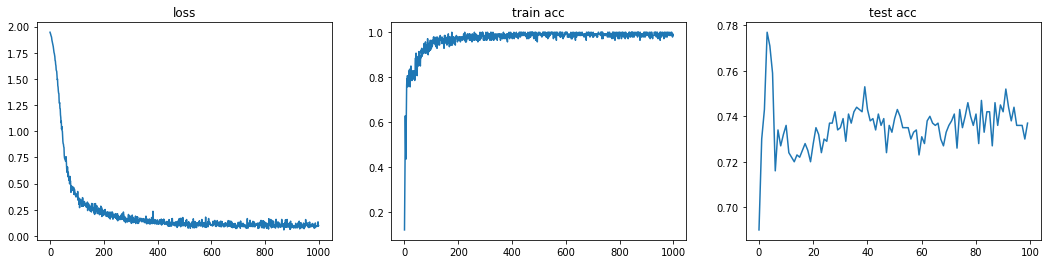

In [90]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

训练后GAT节点表征可视化

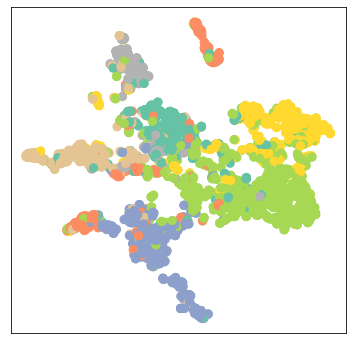

Wall time: 13.6 s


In [73]:
model.eval()

out = model(data.x, data.edge_index)
%time visualize(out, color=data.y)

### 笔记
&emsp;&emsp;主要是对教程内容的简单归纳，对部分进行了补充

1. GCN[【官方文档】](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)  
    &emsp;&emsp;其数学定义为， 
    $$ 
    \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}} \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta}, 
    $$ 
    &emsp;&emsp;其中$\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$表示插入自环的邻接矩阵（使得每一个节点都有一条边连接到自身），$\hat{D}{ii} = \sum{j=0} \hat{A}{ij}$表示$\mathbf{\hat{A}}$的对角线度矩阵（对角线元素为对应节点的度，其余元素为0）。邻接矩阵可以包括不为$1$的值，当邻接矩阵不为{0,1}值时，表示邻接矩阵存储的是边的权重。$\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}} \mathbf{\hat{D}}^{-1/2}$是对称归一化矩阵，它的节点式表述为： 
    $$
    \mathbf{x}^{\prime}i = \mathbf{\Theta} \sum{j \in \mathcal{N}(v) \cup { i }} \frac{e{j,i}}{\sqrt{\hat{d}_j \hat{d}i}} \mathbf{x}j 
    $$ 
    &emsp;&emsp;其中，$\hat{d}i = 1 + \sum{j \in \mathcal{N}(i)} e{j,i}$，$e{j,i}$表示从源节点$j$到目标节点$i$的边的对称归一化系数（默认值为1.0）。
```python
GCNConv(in_channels: int, out_channels: int, improved: bool = False, cached: bool = False, add_self_loops: bool = True, normalize: bool = True, bias: bool = True, **kwargs)
```
    - in_channels ：输入数据维度；
    - out_channels ：输出数据维度；
    - improved ：如果为true，$\mathbf{\hat{A}} = \mathbf{A} + 2\mathbf{I}$，其目的在于增强中心节点自身信息；
    - cached ：是否存储$\mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}} \mathbf{\hat{D}}^{-1/2}$的计算结果以便后续使用，这个参数只应在归纳学习（transductive learning）的场景中设置为true（归纳学习可以简单理解为在训练、验证、测试、推理（inference）四个阶段都只使用一个数据集）；
    - add_self_loops ：是否在邻接矩阵中增加自环边；
    - normalize ：是否添加自环边并在运行中计算对称归一化系数；
    - bias ：是否包含偏置项。
2. GAT[【官方文档】](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv)  
    &emsp;&emsp;其数学定义为，
    $$ 
    \mathbf{x}^{\prime}i = \alpha{i,i}\mathbf{\Theta}\mathbf{x}{i} + \sum{j \in \mathcal{N}(i)} \alpha_{i,j}\mathbf{\Theta}\mathbf{x}{j}, 
    $$ 
    &emsp;&emsp;其中注意力系数$\alpha{i,j}$的计算方法为，
    $$ 
    \alpha_{i,j} = \frac{ \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top} [\mathbf{\Theta}\mathbf{x}_i , \Vert , \mathbf{\Theta}\mathbf{x}j] \right)\right)} {\sum{k \in \mathcal{N}(i) \cup { i }} \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top} [\mathbf{\Theta}\mathbf{x}_i , \Vert , \mathbf{\Theta}\mathbf{x}_k] \right)\right)}. 
    $$
```python
GATConv(in_channels: Union[int, Tuple[int, int]], out_channels: int, heads: int = 1, concat: bool = True, negative_slope: float = 0.2, dropout: float = 0.0, add_self_loops: bool = True, bias: bool = True, **kwargs)
```
    - in_channels ：输入数据维度；
    - out_channels ：输出数据维度；
    - heads ：在GATConv使用多少个注意力模型（Number of multi-head-attentions）；
    - concat ：如为true，不同注意力模型得到的节点表征被拼接到一起（表征维度翻倍），否则对不同注意力模型得到的节点表征求均值；
    - negative_slope ：LeakyReLU angle of the negative slope；
    - dropout ：Dropout probability of the normalized attention coefficients which exposes each node to a stochastically sampled neighborhood during training.
    - add_self_loops ：是否添加自环边并在运行中计算对称归一化系数；
    - bias ：是否包含偏置项。

&emsp;&emsp;在节点表征的学习中，MLP神经网络只考虑了节点自身属性，忽略了节点之间的连接关系，它的结果是最差的；而GCN图神经网络与GAT图神经网络，同时考虑了节点自身信息与周围邻接节点的信息，因此它们的结果都优于MLP神经网络。也就是说，对周围邻接节点的信息的考虑，是图神经网络由于普通深度神经网络的原因。  

&emsp;&emsp;GCN图神经网络与GAT图神经网络的相同点为：  

- 它们都遵循消息传递范式；
- 在邻接节点信息变换阶段，它们都对邻接节点做归一化和线性变换；
- 在邻接节点信息聚合阶段，它们都将变换后的邻接节点信息做求和聚合；
- 在中心节点信息变换阶段，它们都只是简单返回邻接节点信息聚合阶段的聚合结果。  

&emsp;&emsp;GCN图神经网络与GAT图神经网络的区别在于采取的归一化方法不同：  

- 前者根据中心节点与邻接节点的度计算归一化系数，后者根据中心节点与邻接节点的相似度计算归一化系数。
- 前者的归一化方式依赖于图的拓扑结构：不同的节点会有不同的度，同时不同节点的邻接节点的度也不同，于是在一些应用中GCN图神经网络会表现出较差的泛化能力。
- 后者的归一化方式依赖于中心节点与邻接节点的相似度，相似度是训练得到的，因此不受图的拓扑结构的影响，在不同的任务中都会有较好的泛化表现。

### 作业
&emsp;&emsp;此篇文章涉及的代码可见于[codes/learn_node_representation.ipynb](https://github.com/datawhalechina/team-learning-nlp/blob/master/GNN/Markdown%E7%89%88%E6%9C%AC/codes/learn_node_representation.ipynb)，请参照这份代码使用PyG中不同的图卷积模块在PyG的不同数据集上实现节点分类或回归任务。

In [91]:
# 找了一圈没找到合适的数据集。找的几个没有train_mask，不知道怎么处理
# 所以这里还是用Cora，不过稍加处理，增大train的比例
dataset = Planetoid(root='dataset/Cora',
                    name='Cora',
                    split='random',
                    num_train_per_class=100,
                    transform=NormalizeFeatures())

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('======================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(
    f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}'
)
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 700
Training node label rate: 0.26
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


#### MLP

In [93]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        torch.manual_seed(42)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def MLP_train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc

def MLP_test():
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

%time (train_loss, train_acc, test_acc) = result(MLP_train, MLP_test)

[Epoch 10/1000] Loss 1.9165, train acc 0.2757
Accuracy: 0.1600
[Epoch 20/1000] Loss 1.8415, train acc 0.4871
Accuracy: 0.5610
[Epoch 30/1000] Loss 1.7206, train acc 0.5414
Accuracy: 0.5590
[Epoch 40/1000] Loss 1.5854, train acc 0.5586
Accuracy: 0.5870
[Epoch 50/1000] Loss 1.4118, train acc 0.6071
Accuracy: 0.6570
[Epoch 60/1000] Loss 1.2879, train acc 0.6729
Accuracy: 0.6530
[Epoch 70/1000] Loss 1.1475, train acc 0.7000
Accuracy: 0.6660
[Epoch 80/1000] Loss 1.0469, train acc 0.7329
Accuracy: 0.6720
[Epoch 90/1000] Loss 0.9836, train acc 0.7457
Accuracy: 0.6720
[Epoch 100/1000] Loss 0.9314, train acc 0.7500
Accuracy: 0.6740
[Epoch 110/1000] Loss 0.8931, train acc 0.7700
Accuracy: 0.6730
[Epoch 120/1000] Loss 0.8662, train acc 0.7700
Accuracy: 0.6730
[Epoch 130/1000] Loss 0.7930, train acc 0.7957
Accuracy: 0.6780
[Epoch 140/1000] Loss 0.8036, train acc 0.7786
Accuracy: 0.6750
[Epoch 150/1000] Loss 0.7542, train acc 0.8186
Accuracy: 0.6770
[Epoch 160/1000] Loss 0.7582, train acc 0.8200
Ac

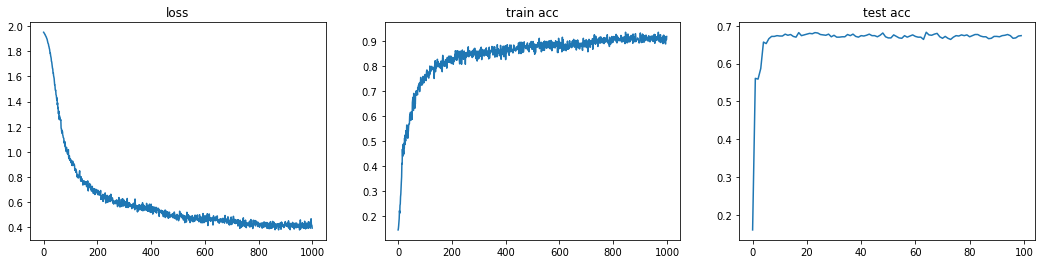

In [94]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

#### GCN

In [95]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

%time (train_loss, train_acc, test_acc) = result(train, test)

[Epoch 10/1000] Loss 1.9006, train acc 0.5500
Accuracy: 0.7110
[Epoch 20/1000] Loss 1.8134, train acc 0.6829
Accuracy: 0.7790
[Epoch 30/1000] Loss 1.6996, train acc 0.7243
Accuracy: 0.7780
[Epoch 40/1000] Loss 1.5558, train acc 0.7386
Accuracy: 0.7920
[Epoch 50/1000] Loss 1.4102, train acc 0.7714
Accuracy: 0.8140
[Epoch 60/1000] Loss 1.2842, train acc 0.7957
Accuracy: 0.8260
[Epoch 70/1000] Loss 1.1355, train acc 0.8057
Accuracy: 0.8270
[Epoch 80/1000] Loss 1.0396, train acc 0.8171
Accuracy: 0.8350
[Epoch 90/1000] Loss 0.9514, train acc 0.8343
Accuracy: 0.8420
[Epoch 100/1000] Loss 0.8838, train acc 0.8429
Accuracy: 0.8460
[Epoch 110/1000] Loss 0.8369, train acc 0.8457
Accuracy: 0.8490
[Epoch 120/1000] Loss 0.7867, train acc 0.8729
Accuracy: 0.8460
[Epoch 130/1000] Loss 0.7475, train acc 0.8671
Accuracy: 0.8510
[Epoch 140/1000] Loss 0.6974, train acc 0.8729
Accuracy: 0.8540
[Epoch 150/1000] Loss 0.6985, train acc 0.8743
Accuracy: 0.8560
[Epoch 160/1000] Loss 0.6380, train acc 0.8914
Ac

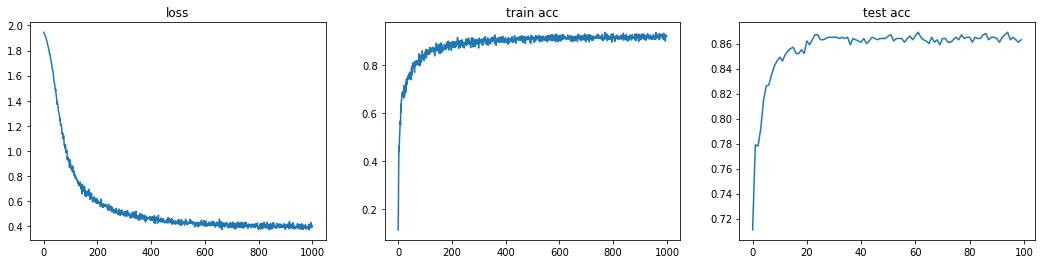

In [97]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

#### GAT

In [98]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(42)
        self.conv1 = GATConv(dataset.num_features, hidden_channels)
        self.conv2 = GATConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    pred = out.argmax(dim=1)
    correct = float(pred[data.train_mask].eq(data.y[data.train_mask]).sum().item())
    acc = correct / data.train_mask.sum().item()
    optimizer.step()  # Update parameters based on gradients.
    return loss.cpu().detach().data.item(), acc

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

%time (train_loss, train_acc, test_acc) = result(train, test)

[Epoch 10/1000] Loss 1.8780, train acc 0.6686
Accuracy: 0.7510
[Epoch 20/1000] Loss 1.7408, train acc 0.7443
Accuracy: 0.8070
[Epoch 30/1000] Loss 1.5496, train acc 0.7286
Accuracy: 0.8190
[Epoch 40/1000] Loss 1.3126, train acc 0.7400
Accuracy: 0.8300
[Epoch 50/1000] Loss 1.0919, train acc 0.7857
Accuracy: 0.8220
[Epoch 60/1000] Loss 0.9421, train acc 0.8086
Accuracy: 0.8060
[Epoch 70/1000] Loss 0.8343, train acc 0.8200
Accuracy: 0.8080
[Epoch 80/1000] Loss 0.7537, train acc 0.8257
Accuracy: 0.8070
[Epoch 90/1000] Loss 0.6710, train acc 0.8386
Accuracy: 0.8090
[Epoch 100/1000] Loss 0.6312, train acc 0.8371
Accuracy: 0.8040
[Epoch 110/1000] Loss 0.5949, train acc 0.8643
Accuracy: 0.8130
[Epoch 120/1000] Loss 0.5385, train acc 0.8929
Accuracy: 0.8030
[Epoch 130/1000] Loss 0.5442, train acc 0.8771
Accuracy: 0.8200
[Epoch 140/1000] Loss 0.5180, train acc 0.8886
Accuracy: 0.8190
[Epoch 150/1000] Loss 0.4895, train acc 0.8814
Accuracy: 0.8130
[Epoch 160/1000] Loss 0.4946, train acc 0.8871
Ac

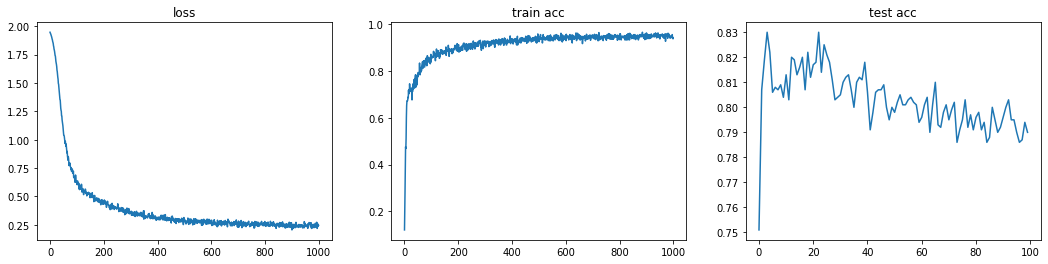

In [99]:
plt.figure(figsize=(18,4))
plt.subplot(1,3,1);plt.plot(train_loss);plt.title('loss')
plt.subplot(1,3,2);plt.plot(train_acc);plt.title('train acc')
plt.subplot(1,3,3);plt.plot(test_acc);plt.title('test acc')                    
plt.show()

#### 小结

1. 从结果上看，GCN和GAT确实性能优于MLP（特别是数据量较少时模型也能保持一定的性能）；
2. 在提高train的比重后，MLP的分数得到了大幅提升（0.55->0.67），GCN有小幅提升（0.80->0.86），GAT可能出现了过拟合，在test上的分数波动降低（但我不知道如何调整）；
3. 从运行时间上看，MLP(5.5s)<GCN(15.5s)<GAT(37.7s)